# Complete cartography

> In this experiment, we'll train on a reduced dataset with less initial conditions, and show how ML can fill the gaps in between the points in the phase space.

In [66]:
from tsai.all import *
from mlchaos.all import *
import papermill as pm
import pandas as pd
import wandb
from plotnine import *

In [67]:
if wandb.config is None:
    print('No config!!!')
else:
    print(wandb.config)

<function PreInitCallable.<locals>.preinit_wrapper at 0x7f65d38ad040>


In [68]:
base_path = Path.home()

In [69]:
config = AttrDict(
    cartography_folderpath = base_path/'data/fli_rotnum/model_1/eps=0.01', # *
    train_cond = None,
    test_cond = None,
    #train_cond = lambda data: (data.x[:, 1, 0] <= 0.6), # For extrapolation
    #test_cond = lambda data: data.x[:, 1, 0]> 0.6, # If None, the difference set data\train_cond will be used
    reduction_factor = 7, # For interpolation: One every `reduction_factor` points from the dataset will be kept. 
    labelling_method = 'birav'
)

In [70]:
fnames_poinc_map = [config.cartography_folderpath/'Poincare.plt']
fnames_index = [config.cartography_folderpath/'index_fli_rotnum_birav.plt']
fnames = L(fnames_poinc_map).zipwith(fnames_index)
fnames

(#1) [(Path('/home/victor/data/fli_rotnum/model_1/eps=0.01/Poincare.plt'), Path('/home/victor/data/fli_rotnum/model_1/eps=0.01/index_fli_rotnum_birav.plt'))]

In [71]:
data = TSDataChaos.from_poincare_and_index_files(fnames, index_col=index_cols[config.labelling_method])
data

TSDataChaos:
 Datasets names (concatenated): ['eps=0.01']
 Filenames:                     [(Path('/home/victor/data/fli_rotnum/model_1/eps=0.01/Poincare.plt'), Path('/home/victor/data/fli_rotnum/model_1/eps=0.01/index_fli_rotnum_birav.plt'))]
 Data shape: (10201, 2, 200)
 Targets shape: (10201,)
 Nb Samples: 10201
 Nb Channels:           2
 Sequence Length: 200

Remove the uncertain motions (class == -1)

In [72]:
data.remove_uncertainty()
data

TSDataChaos:
 Datasets names (concatenated): ['eps=0.01']
 Filenames:                     [(Path('/home/victor/data/fli_rotnum/model_1/eps=0.01/Poincare.plt'), Path('/home/victor/data/fli_rotnum/model_1/eps=0.01/index_fli_rotnum_birav.plt'))]
 Data shape: (10197, 2, 200)
 Targets shape: (10197,)
 Nb Samples: 10197
 Nb Channels:           2
 Sequence Length: 200

In [73]:
ylims = [data.x[:, 1].min(), data.x[:, 1].max()]
ylims

[-0.551154664774345, 1.55115466477387]

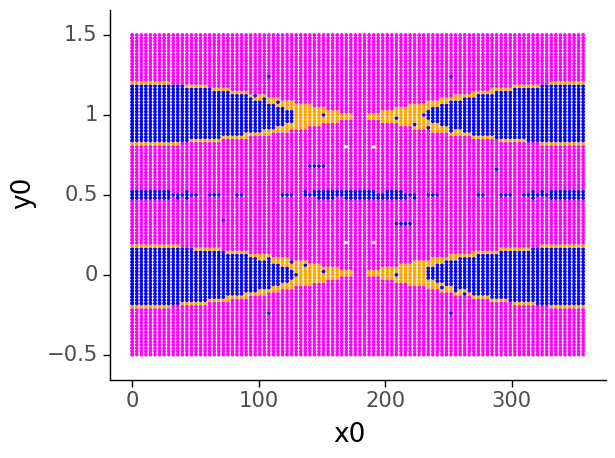

<ggplot: (8754171848144)>

In [74]:
p = show_labelled_ic_map(data.x, 
                     preds=data.y.astype(int), 
                     color_values=['orange', 'magenta', 'blue'])
p = p + theme_classic(base_size=19)
p

We'll create a reduced version of this dataset, with an evenly spaced grid of points in the space

In [75]:
train_data = data.reduce(cond=config.train_cond,
                         reduction_factor=config.reduction_factor)

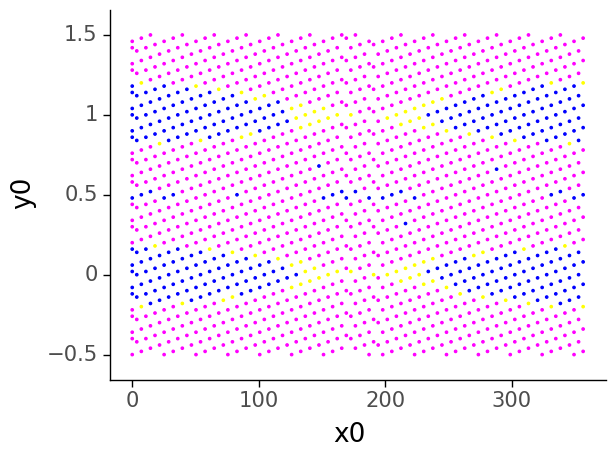

<ggplot: (8754172205752)>

In [76]:
p = show_labelled_ic_map(train_data.x, train_data.y.astype(int), 
                     vocab=['chaotic', 'rotational', 'librational'], 
                     color_values=dict([('chaotic', 'yellow'), 
                                   ('rotational', 'magenta'), 
                                   ('librational', 'blue')]),
                     ylim=ylims)
p = p + theme_classic(base_size=19)
p

In [77]:
# Default data to test on remaining data from reduced dataset
test_cond = ifnone(config.test_cond, 
                  lambda data: np.mod(np.arange(data.x.shape[0]), config.reduction_factor) != 0)
test_data = data.reduce(cond=test_cond)

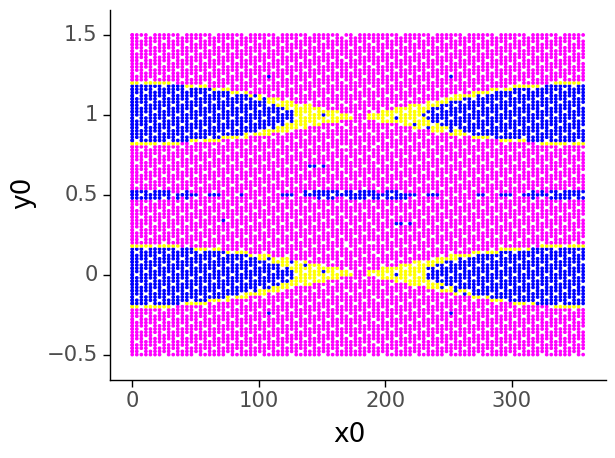

<ggplot: (8754172100103)>

In [78]:
p = show_labelled_ic_map(test_data.x, test_data.y.astype(int), 
                     vocab=['chaotic', 'rotational', 'librational'], 
                     color_values=dict([('chaotic', 'yellow'), 
                                   ('rotational', 'magenta'), 
                                   ('librational', 'blue')]),
                     ylim=ylims)
p = p + theme_classic(base_size=19)
p

Dump the two datasets (reduced and test) to be used by the main program for motion classification. The reduced dataset will be used for training and the test one will be used for testing

In [16]:
tmp_train_path = base_path/'tmp_train'
tmp_test_path = base_path/'tmp_test'
poinc_fname = 'Poincare.plt'
index_fname = 'index_fli_rotnum_birav.plt'

In [17]:
tmp_train_path.mkdir(exist_ok=True)
tmp_test_path.mkdir(exist_ok=True)

In [18]:
train_data.export(tmp_train_path/poinc_fname, tmp_train_path/index_fname)
test_data.export(tmp_test_path/poinc_fname, tmp_test_path/index_fname)

Execute the notebook for motion classification with papermill, setting the config 
to point to the tmp data folders created

In [19]:
%%capture
pm.execute_notebook(base_path/'work/nbs/motion_classification_time_series.ipynb', 
                    output_path=base_path/'pm_output.ipynb', 
                    parameters={
                        'config.cartography_fname': config.cartography_folderpath 
                        'config.trainvalid_dataset_folders': [str(tmp_train_path)],
                        'config.val_ds': None,
                        'config.test_folder': str(tmp_test_path),
                        'config.labelling_method': config.labelling_method,
                        'config.resampling_period': None
                    })

In [20]:
#(tmp_train_path/poinc_fname).unlink()
#(tmp_train_path/index_fname).unlink()
#tmp_train_path.rmdir()

Traceback (most recent call last):
  File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.8/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.8/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelapp.py", line 677, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.8/dist-packages/tornado/platform/asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
    self._run_once()
  File "/usr/lib/python3.8/asyncio/base_events.py", line 1844, in _run_once
    handle = self._ready.popleft()
IndexError: pop from an empty deque
